#Import Libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Data Importing and Exploration

### Pre-Processing Data

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT08
0,USW00093134,"LOS ANGELES DOWNTOWN USC, CA US",2016-01-01,2.46,NaN,0.00,NaN,64,43,10.0,30.0,8.1,11.0,NaN,NaN,1.0
1,USW00093134,"LOS ANGELES DOWNTOWN USC, CA US",2016-01-02,2.01,NaN,0.00,NaN,65,47,270.0,30.0,6.0,8.9,NaN,NaN,NaN
2,USW00093134,"LOS ANGELES DOWNTOWN USC, CA US",2016-01-03,0.67,NaN,0.00,NaN,62,44,150.0,150.0,10.1,14.1,NaN,NaN,NaN
3,USW00093134,"LOS ANGELES DOWNTOWN USC, CA US",2016-01-04,1.34,NaN,0.01,NaN,69,55,270.0,280.0,8.1,14.1,NaN,NaN,NaN
4,USW00093134,"LOS ANGELES DOWNTOWN USC, CA US",2016-01-05,2.46,NaN,1.61,NaN,59,49,140.0,140.0,10.1,16.1,1.0,1.0,NaN


In [3]:
df['DATE'].min()

'2016-01-01'

In [4]:
print("Total:", df.shape[0])
#Number of nan values in each column
for i in df.columns:
  print( i, sum( ( ( (df[i] != df[i]).astype(int) ) ) ) )

Total: 1827
STATION 0
NAME 0
DATE 0
AWND 4
PGTM 1765
PRCP 0
TAVG 1827
TMAX 0
TMIN 0
WDF2 5
WDF5 18
WSF2 4
WSF5 18
WT01 1276
WT02 1788
WT08 966


In [5]:
def pre_processing_train(df):
  Y = (df['PRCP'] > 0).astype(int)
  df = df.drop(['PGTM', 'TAVG', 'WT01', 'WT02', 'NAME', 'STATION', 'PRCP'], axis = 1)
  df['DATE'] = df['DATE'].apply(pd.to_datetime)
  df['DATE'] = (df['DATE'] - pd.to_datetime('2016-01-01 00:00:00')).dt.total_seconds()
  df[df.columns] = scaler.fit_transform(df[df.columns])
  df = df.fillna(2)
  X = df

  return X, Y

In [6]:
X, Y = pre_processing_train(df)
X.head()

,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT08
0,0.000000,0.305590,0.203390,0.121951,0.000000,0.057143,0.287293,0.178571,0.0
1,0.000548,0.249689,0.220339,0.219512,0.742857,0.057143,0.171271,0.103571,2.0
2,0.001095,0.083230,0.169492,0.146341,0.400000,0.400000,0.397790,0.289286,2.0
3,0.001643,0.166460,0.288136,0.414634,0.742857,0.771429,0.287293,0.289286,2.0
4,0.002191,0.305590,0.118644,0.268293,0.371429,0.371429,0.397790,0.360714,2.0


In [7]:
Y.head()

0    0
1    0
2    0
3    1
4    1
Name: PRCP, dtype: int64

### Train_Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3)
X_train.head()

,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT08
1028,0.562979,0.166460,0.457627,0.609756,0.742857,0.771429,0.287293,0.289286,0.0
341,0.186747,0.110559,0.220339,0.292683,0.771429,0.742857,0.331492,0.250000,0.0
1383,0.757393,0.195031,0.525424,0.536585,0.742857,0.714286,0.287293,0.250000,0.0
1347,0.737678,0.249689,0.508475,0.682927,0.742857,0.771429,0.508287,0.464286,0.0
30,0.016429,0.555280,0.118644,0.292683,0.742857,0.771429,0.729282,0.928571,2.0


In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1278, 9)
(1278,)
(549, 9)
(549,)


# Logistic Regression

####Model

In [10]:
from sklearn.linear_model import LogisticRegression
def Logistic_reg(X_train, Y_train, X_test, Y_test, tol_val, C_val, max_iter_val):
  clf = LogisticRegression(penalty='l2', class_weight='balanced', tol=tol_val, C=C_val, random_state=0, max_iter = max_iter_val).fit(X_train, Y_train)
  train_score = clf.score(X_train, Y_train)
  test_score = clf.score(X_test, Y_test)
  auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
  auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

  return clf, train_score, test_score, auc_score1, auc_score2

####Hyperparameter Tuning

In [11]:
max_iter = [1e+4]
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
C = [1, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6]
values = []
for k in max_iter:
  for i in tol:
    for j in C:
      clf, train_score, test_score, auc_score_train, auc_score_test = Logistic_reg(X_train, Y_train, X_test, Y_test, i, j, k)

      values.append([k, i, j, train_score, test_score, auc_score_train, auc_score_test])

In [12]:
values_tables = pd.DataFrame(values, columns = ['max_iter', 'tol','C','train_score', 'test_score', 'auc_train_score', 'auc_test_score'])
values_tables.head()

,max_iter,tol,C,train_score,test_score,auc_train_score,auc_test_score
0,10000.0,0.000001,1.0,0.861502,0.856102,0.864100,0.837710
1,10000.0,0.000001,10.0,0.863850,0.857923,0.873379,0.846970
2,10000.0,0.000001,100.0,0.863067,0.861566,0.868954,0.857239
3,10000.0,0.000001,1000.0,0.863850,0.863388,0.869384,0.858249
4,10000.0,0.000001,10000.0,0.863850,0.863388,0.869384,0.858249


####Accuracy Vs AUR_ROC

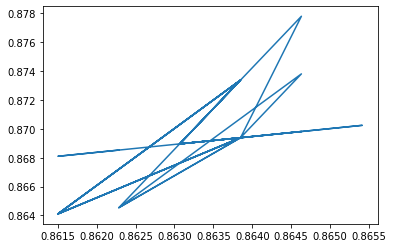

In [13]:
plt.plot(values_tables['train_score'], values_tables['auc_train_score'])

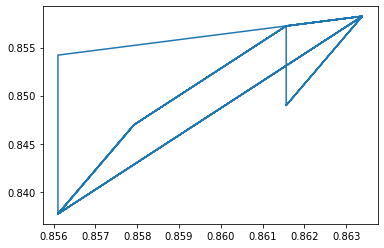

In [14]:
plt.plot(values_tables['test_score'], values_tables['auc_test_score'])

In [15]:
print(values_tables['test_score'].max(),values_tables['auc_test_score'].max(), values_tables['train_score'].max(), values_tables['auc_train_score'].max())

0.8633879781420765 0.8582491582491583 0.865414710485133 0.8778039424209046


In [16]:
print(values_tables['test_score'].idxmax(),values_tables['auc_test_score'].idxmax(), values_tables['train_score'].idxmax(), values_tables['auc_train_score'].idxmax())

3 3 46 43


####Getting Hyperparameters with best scores

In [17]:
for i in [3, 46, 43]:
  print(values_tables[i:(i+1)])

   max_iter       tol       C  ...  test_score  auc_train_score  auc_test_score
3   10000.0  0.000001  1000.0  ...    0.863388         0.869384        0.858249

[1 rows x 7 columns]
    max_iter  tol        C  ...  test_score  auc_train_score  auc_test_score
46   10000.0  1.0  10000.0  ...    0.863388         0.870242        0.858249

[1 rows x 7 columns]
    max_iter  tol     C  ...  test_score  auc_train_score  auc_test_score
43   10000.0  1.0  10.0  ...    0.856102         0.877804        0.854209

[1 rows x 7 columns]


####Final Model

In [18]:
clf_logistic, train_score_logistic, test_score_logistic, auc_train_score_logistic, auc_test_score_logistic = Logistic_reg(X_train, Y_train, X_test, Y_test,0.000001,1000.0 ,1e+7)
print(train_score_logistic, auc_train_score_logistic, test_score_logistic, auc_test_score_logistic)

0.863849765258216 0.8693835694481371 0.8633879781420765 0.8582491582491583


# Support Vector Machine

####Model

In [21]:
from sklearn import svm
def svm_model(X_train, Y_train, X_test, Y_test, C_val, tol_val):
  clf = svm.SVC(C=C_val,tol=tol_val,class_weight='balanced'
                ,random_state=0).fit(X_train, Y_train)
  
  train_score = clf.score(X_train, Y_train)
  test_score = clf.score(X_test, Y_test)
  auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
  auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

  return clf, train_score, test_score, auc_score1, auc_score2

####Hyperparameter Tuning

In [22]:
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
C = [1, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6]
vals_svm = []
for i in tol:
  for j in C:
    clf, train_score, test_score, auc_train_score, auc_test_score = svm_model(X_train, Y_train, X_test, Y_test, j, i)
    vals_svm.append([i, j, train_score, auc_train_score, test_score, auc_test_score])

In [23]:
vals_svm_table = pd.DataFrame(vals_svm, columns = ['tol','C','train_score', 'auc_train_score', 'test_score','auc_test_score'])
vals_svm_table.head()

,tol,C,train_score,auc_train_score,test_score,auc_test_score
0,0.000001,1.0,0.852895,0.883353,0.839709,0.820370
1,0.000001,10.0,0.870110,0.908777,0.857923,0.813973
2,0.000001,100.0,0.902973,0.934794,0.872495,0.780808
3,0.000001,1000.0,0.933490,0.951533,0.883424,0.745623
4,0.000001,10000.0,0.967919,0.978408,0.894353,0.702189


####Accuracy Vs AUR_ROC

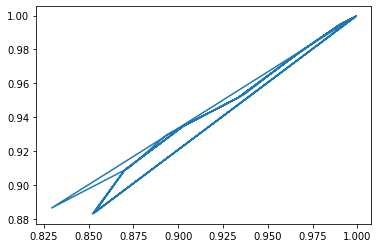

In [24]:
plt.plot(vals_svm_table['train_score'], vals_svm_table['auc_train_score'])

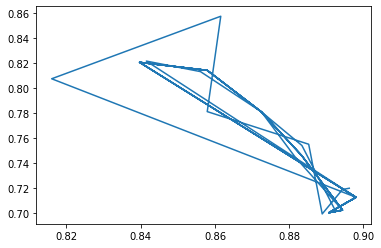

In [25]:
plt.plot(vals_svm_table['test_score'], vals_svm_table['auc_test_score'])

In [26]:
print(vals_svm_table['test_score'].max(),vals_svm_table['auc_test_score'].max(), vals_svm_table['train_score'].max(), vals_svm_table['auc_train_score'].max())

0.8979963570127505 0.8572390572390572 0.9992175273865415 0.9995708154506439


In [27]:
print(vals_svm_table['test_score'].idxmax(),vals_svm_table['auc_test_score'].idxmax(), vals_svm_table['train_score'].idxmax(), vals_svm_table['auc_train_score'].idxmax())

6 43 6 6


####Getting Hyperparameters with best scores

In [28]:
for i in [43, 6]:
  print(vals_svm_table[i:(i+1)])

    tol     C  train_score  auc_train_score  test_score  auc_test_score
43  1.0  10.0     0.872457         0.910065    0.861566        0.857239
        tol          C  ...  test_score  auc_test_score
6  0.000001  1000000.0  ...    0.897996        0.712458

[1 rows x 6 columns]


####Final Model

In [29]:
clf_svm, train_score_svm, test_score_svm, auc_train_score_svm, auc_test_score_svm = svm_model(X_train, Y_train, X_test, Y_test,10.0,1.0)
print(train_score_svm, auc_train_score_svm, test_score_svm, auc_test_score_svm)

0.8724569640062598 0.9100649473964071 0.8615664845173042 0.8572390572390572


# Gradient Boosting Classifier

####Model

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boost(X_train, Y_train, X_test, Y_test, alpha, tol_value):
  clf = GradientBoostingClassifier(learning_rate=alpha, random_state=0,
                             tol=tol_value).fit(X_train, Y_train)
                            
  train_score = clf.score(X_train, Y_train)
  test_score = clf.score(X_test, Y_test)
  auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
  auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

  return clf, train_score, test_score, auc_score1, auc_score2

####Hyperparameter Tuning

In [32]:
alpha = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
val_gradient = []
for i in tol:
  for j in alpha:
    clf, train_score, test_score,  auc_train_score, auc_test_score = gradient_boost(X_train, Y_train, X_test, Y_test, j, i)
    val_gradient.append([i, j, train_score, auc_train_score,  test_score,  auc_test_score])

In [33]:
val_gradient_table = pd.DataFrame(val_gradient, columns = ['tol','alpha','train_score', 'auc_train_score',  'test_score',  'auc_test_score'])
val_gradient_table.head()

,tol,alpha,train_score,auc_train_score,test_score,auc_test_score
0,0.000001,0.000001,0.911581,0.500000,0.901639,0.500000
1,0.000001,0.000010,0.911581,0.500000,0.901639,0.500000
2,0.000001,0.000100,0.911581,0.500000,0.901639,0.500000
3,0.000001,0.001000,0.911581,0.500000,0.901639,0.500000
4,0.000001,0.010000,0.938185,0.662429,0.910747,0.562795


####Accuracy Vs AUR_ROC

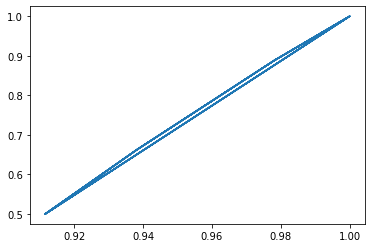

In [34]:
plt.plot(val_gradient_table['train_score'], val_gradient_table['auc_train_score'])

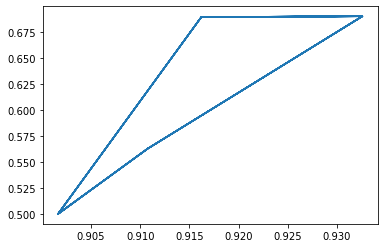

In [35]:
plt.plot(val_gradient_table['test_score'], val_gradient_table['auc_test_score'])

In [36]:
print(val_gradient_table['test_score'].max(),val_gradient_table['auc_test_score'].max(), val_gradient_table['train_score'].max(), val_gradient_table['auc_train_score'].max())

0.9326047358834244 0.6904040404040402 1.0 1.0


In [37]:
print(val_gradient_table['test_score'].idxmax(),val_gradient_table['auc_test_score'].idxmax(), val_gradient_table['train_score'].idxmax(), val_gradient_table['auc_train_score'].idxmax())

5 5 6 6


####Getting Hyperparameters with best scores

In [38]:
for i in [5, 6]:
  print(val_gradient_table[i:(i+1)])

        tol  alpha  train_score  auc_train_score  test_score  auc_test_score
5  0.000001    0.1     0.978091         0.888093    0.932605        0.690404
        tol  alpha  train_score  auc_train_score  test_score  auc_test_score
6  0.000001    1.0          1.0              1.0    0.916211        0.689562


####Final Model

In [39]:
clf_grd_boost, train_score_grd_boost, test_score_grd_boost, auc_train_score_grd_boost, auc_test_score_grd_boost = gradient_boost(X_train, Y_train, X_test, Y_test,0.1,0.000001)
print(train_score_grd_boost, auc_train_score_grd_boost, test_score_grd_boost, auc_test_score_grd_boost)

0.9780907668231612 0.8880929773253827 0.9326047358834244 0.6904040404040402


# Random Forest

####Model

In [41]:
from sklearn.ensemble import RandomForestClassifier
def random_forest(X_train, Y_train, X_test, Y_test, no_of_trees_val, max_depth_val):
      clf = RandomForestClassifier(n_estimators = no_of_trees_val, max_depth = max_depth_val,
                                   random_state=0, class_weight= "balanced").fit(X_train, Y_train)
      train_score = clf.score(X_train, Y_train)
      test_score = clf.score(X_test, Y_test)
      auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
      auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

      return clf, train_score, test_score, auc_score1, auc_score2

####Hyperparameter Tuning

In [42]:
no_of_trees = [1, 2, 5, 10, 15, 20, 50, 100]
max_depth = [1, 2, 5, 1e+1, 50, 100]
val_random_forest = []
for i in no_of_trees:
  for j in max_depth:
      clf, train_score, test_score, auc_train_score, auc_test_score = random_forest(X_train, Y_train, X_test, Y_test, i, j)
      val_random_forest.append([i, j, train_score, auc_train_score, test_score, auc_test_score])

In [43]:
table_random_forest = pd.DataFrame(val_random_forest, columns = ['no_of_trees','max_depth','train_score', 'auc_train_score', 'test_score','auc_test_score'])
table_random_forest.head()

,no_of_trees,max_depth,train_score,auc_train_score,test_score,auc_test_score
0,1,1.0,0.828638,0.850070,0.812386,0.805219
1,1,2.0,0.807512,0.846473,0.794171,0.803367
2,1,5.0,0.923318,0.870037,0.872495,0.756061
3,1,10.0,0.958529,0.873368,0.881603,0.637374
4,1,50.0,0.967919,0.878518,0.881603,0.653872


####Accuracy Vs AUR_ROC

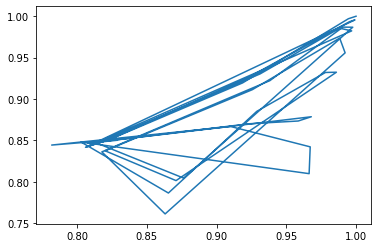

In [44]:
plt.plot(table_random_forest['train_score'], table_random_forest['auc_train_score'])

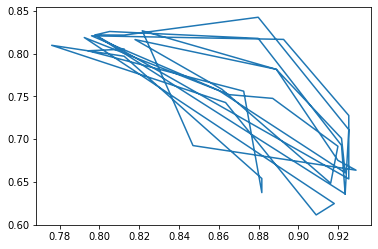

In [45]:
plt.plot(table_random_forest['test_score'], table_random_forest['auc_test_score'])

In [46]:
print(table_random_forest['test_score'].max(),table_random_forest['auc_test_score'].max(), table_random_forest['train_score'].max(), table_random_forest['auc_train_score'].max())

0.9289617486338798 0.8425925925925926 1.0 1.0


In [47]:
print(table_random_forest['test_score'].idxmax(),table_random_forest['auc_test_score'].idxmax(), table_random_forest['train_score'].idxmax(), table_random_forest['auc_train_score'].idxmax())

22 44 46 46


####Getting Hyperparameters with best scores

In [48]:
for i in [22, 44, 46]:
  print(table_random_forest[i:(i+1)])

    no_of_trees  max_depth  ...  test_score  auc_test_score
22           10       50.0  ...    0.928962        0.663636

[1 rows x 6 columns]
    no_of_trees  max_depth  ...  test_score  auc_test_score
44          100        5.0  ...    0.879781        0.842593

[1 rows x 6 columns]
    no_of_trees  max_depth  ...  test_score  auc_test_score
46          100       50.0  ...    0.923497        0.635859

[1 rows x 6 columns]


####Final Model

In [49]:
clf_random_forest, train_score_random_forest, test_score_random_forest, auc_train_score_random_forest, auc_test_score_random_forest = random_forest(X_train, Y_train, X_test, Y_test,100,5)
print(train_score_random_forest, auc_train_score_random_forest, test_score_random_forest, auc_test_score_random_forest)

0.918622848200313 0.9194044589616014 0.8797814207650273 0.8425925925925926


# Multi Layer Perceptron

####Model

In [51]:
from sklearn.neural_network import MLPClassifier
def MLP(X_train, Y_train, X_test, Y_test, alpha_val, max_iterations, tol_val):
  clf = MLPClassifier(learning_rate_init=alpha_val,
                      max_iter=max_iterations,tol=tol_val).fit(X_train, Y_train)

  train_score = clf.score(X_train, Y_train)
  test_score = clf.score(X_test, Y_test)
  auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
  auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

  return clf, train_score, test_score, auc_score1, auc_score2

####Hyperparameter Tuning

In [52]:
max_iter = [10000]
learning_rate = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
tol_val = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
vals_MLP = []
for i in max_iter:
  for j in learning_rate:
    for k in tol_val:
      clf, train_score, test_score, auc_score1, auc_score2 = MLP(X_train, Y_train, X_test, Y_test, j, i, k)
      vals_MLP.append([i, j, k, train_score, test_score, auc_score1, auc_score2])
MLP_table = pd.DataFrame(data = vals_MLP, columns = ['max_iter', 'learning_rate', 'tol_val', 'train_score', 'test_score', 'auc_score_train', 'auc_score_test'])
MLP_table.head()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,max_iter,learning_rate,tol_val,train_score,test_score,auc_score_train,auc_score_test
0,10000,0.000001,0.000001,0.911581,0.901639,0.500000,0.500000
1,10000,0.000001,0.000010,0.911581,0.901639,0.500000,0.500000
2,10000,0.000001,0.000100,0.911581,0.901639,0.500000,0.500000
3,10000,0.000001,0.001000,0.128326,0.138434,0.421999,0.472727
4,10000,0.000001,0.010000,0.601721,0.584699,0.589757,0.555219


####Accuracy Vs AUR_ROC

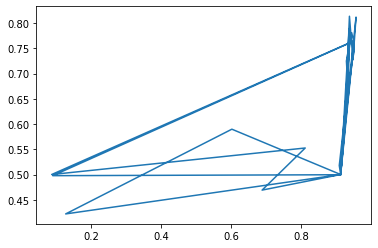

In [53]:
plt.plot(MLP_table['train_score'], MLP_table['auc_score_train'])

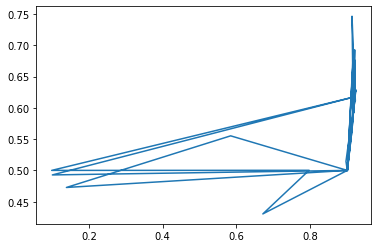

In [54]:
plt.plot(MLP_table['test_score'], MLP_table['auc_score_test'])

In [55]:
print(MLP_table['test_score'].max(),MLP_table['auc_score_test'].max(), MLP_table['train_score'].max(), MLP_table['auc_score_train'].max())

0.9253187613843351 0.7462962962962965 0.9553990610328639 0.8134034714573284


In [56]:
print(MLP_table['test_score'].idxmax(),MLP_table['auc_score_test'].idxmax(), MLP_table['train_score'].idxmax(), MLP_table['auc_score_train'].idxmax())

22 35 30 35


####Getting Hyperparameters with best scores

In [57]:
for i in [22, 30, 35]:
  print(MLP_table[i:(i+1)])
  print(MLP_table[i:(i+1)].tol_val)

    max_iter  learning_rate  ...  auc_score_train  auc_score_test
22     10000          0.001  ...         0.751916         0.62862

[1 rows x 7 columns]
22    0.00001
Name: tol_val, dtype: float64
    max_iter  learning_rate  ...  auc_score_train  auc_score_test
30     10000           0.01  ...         0.811717        0.676094

[1 rows x 7 columns]
30    0.0001
Name: tol_val, dtype: float64
    max_iter  learning_rate  ...  auc_score_train  auc_score_test
35     10000            0.1  ...         0.813403        0.746296

[1 rows x 7 columns]
35    0.000001
Name: tol_val, dtype: float64


####Final Model

In [61]:
clf_MLP, train_score_MLP, test_score_MLP, auc_train_score_MLP, auc_test_score_MLP = MLP(X_train, Y_train, X_test, Y_test,0.1, 100000, 0.000001)
print(train_score_MLP, auc_train_score_MLP, test_score_MLP, auc_test_score_MLP)

0.94679186228482 0.8069960879638421 0.9180327868852459 0.6905723905723906


#Best Model Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
def represent_best(X_train, Y_train, X_test, Y_test, clf, train_score, auc_train_score, test_score, auc_test_score):
  print("Train Data: \n\n")
  print("Accuracy:", train_score, "\n")
  print("AUC_ROC Score:", auc_train_score, "\n")
  print("Confusion Matrix Train\n")
  cm1 = confusion_matrix(Y_train, clf.predict(X_train) , labels=clf.classes_)
  disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                           display_labels=clf.classes_)
  disp1.plot()
  plt.show()

  print("Test Data: \n\n")
  print("Accuracy:", test_score, "\n")
  print("AUC_ROC Score:", auc_test_score, "\n")
  print("Confusion Matrix Train")
  cm2  = confusion_matrix(Y_test, clf.predict(X_test), labels=clf.classes_)
  disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                           display_labels=clf.classes_)
  disp2.plot()
  plt.show()

####Logistic Regression Confusion Matrix

Train Data: 


Accuracy: 0.863849765258216 

AUC_ROC Score: 0.8693835694481371 

Confusion Matrix Train



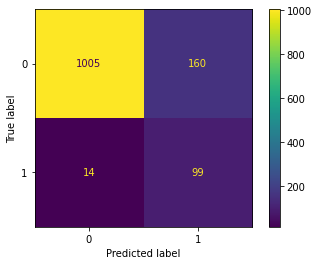

Test Data: 


Accuracy: 0.8633879781420765 

AUC_ROC Score: 0.8582491582491583 

Confusion Matrix Train


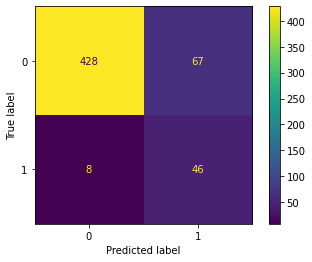

In [20]:
represent_best(X_train, Y_train, X_test, Y_test, clf_logistic, train_score_logistic, auc_train_score_logistic, test_score_logistic, auc_test_score_logistic)

####SVM Confusion Matrix

Train Data: 


Accuracy: 0.8724569640062598 

AUC_ROC Score: 0.9100649473964071 

Confusion Matrix Train



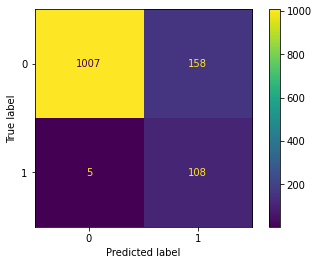

Test Data: 


Accuracy: 0.8615664845173042 

AUC_ROC Score: 0.8572390572390572 

Confusion Matrix Train


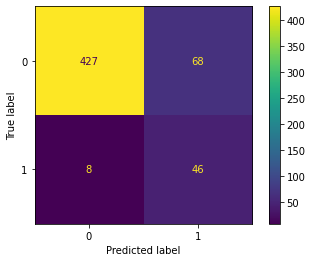

In [30]:
represent_best(X_train, Y_train, X_test, Y_test, clf_svm, train_score_svm, auc_train_score_svm, test_score_svm, auc_test_score_svm)

####Gradient Boost Confusion Matrix

Train Data: 


Accuracy: 0.9780907668231612 

AUC_ROC Score: 0.8880929773253827 

Confusion Matrix Train



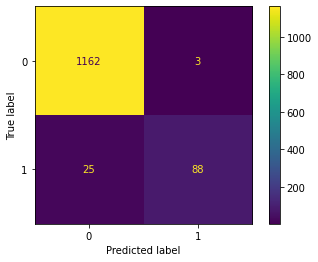

Test Data: 


Accuracy: 0.9326047358834244 

AUC_ROC Score: 0.6904040404040402 

Confusion Matrix Train


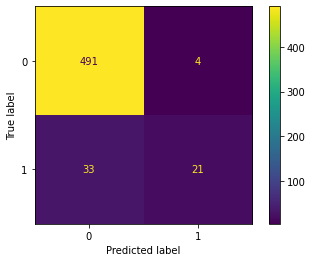

In [40]:
represent_best(X_train, Y_train, X_test, Y_test, clf_grd_boost, train_score_grd_boost, auc_train_score_grd_boost, test_score_grd_boost, auc_test_score_grd_boost)

####Random Forest Confusion Matrix

Train Data: 


Accuracy: 0.918622848200313 

AUC_ROC Score: 0.9194044589616014 

Confusion Matrix Train



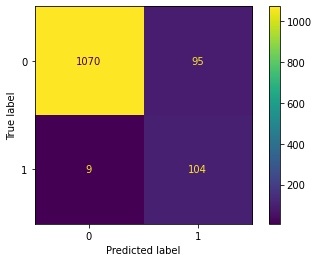

Test Data: 


Accuracy: 0.8797814207650273 

AUC_ROC Score: 0.8425925925925926 

Confusion Matrix Train


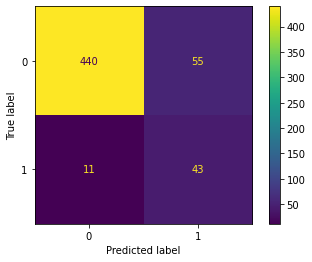

In [50]:
represent_best(X_train, Y_train, X_test, Y_test, clf_random_forest, train_score_random_forest, auc_train_score_random_forest, test_score_random_forest, auc_test_score_random_forest)

####MLP Confusion Matrix

Train Data: 


Accuracy: 0.94679186228482 

AUC_ROC Score: 0.8069960879638421 

Confusion Matrix Train



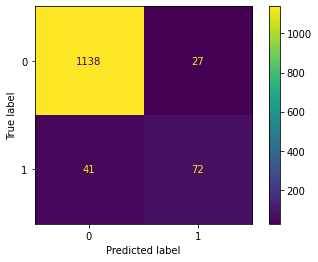

Test Data: 


Accuracy: 0.9180327868852459 

AUC_ROC Score: 0.6905723905723906 

Confusion Matrix Train


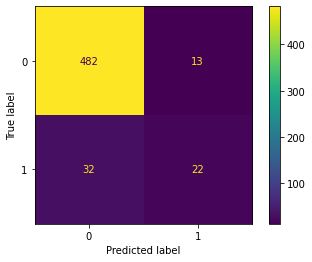

In [62]:
represent_best(X_train, Y_train, X_test, Y_test, clf_MLP, train_score_MLP, auc_train_score_MLP, test_score_MLP, auc_test_score_MLP)